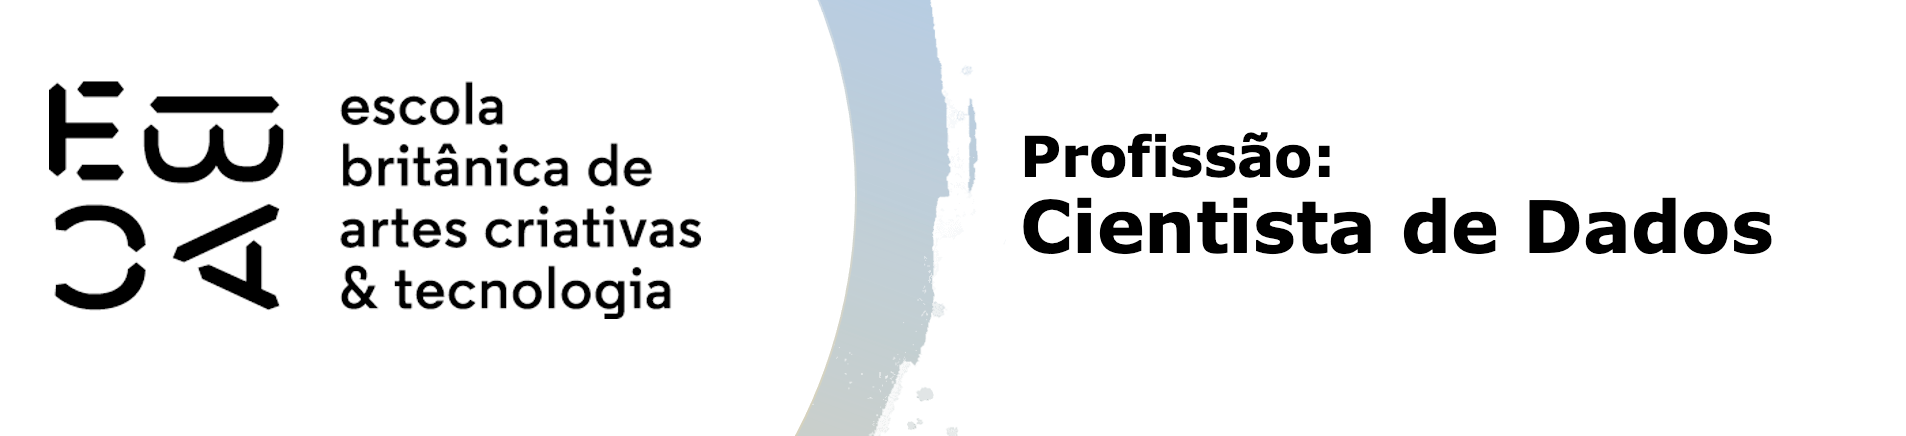

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import pickle

from pycaret.classification import *

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression


In [2]:
import pandas as pd

df = pd.read_feather('../Dados/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
last_3_months = df['data_ref'].unique()[-3:]
print(f"Meses para validação OOT: {last_3_months}")

df_train = df[~df['data_ref'].isin(last_3_months)].copy()
df_oot = df[df['data_ref'].isin(last_3_months)].copy()

print(f"Tamanho da base de treino: {df_train.shape}")
print(f"Tamanho da base OOT: {df_oot.shape}")

Meses para validação OOT: <DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]
Tamanho da base de treino: (600000, 15)
Tamanho da base OOT: (150000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

Linhas por mês:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


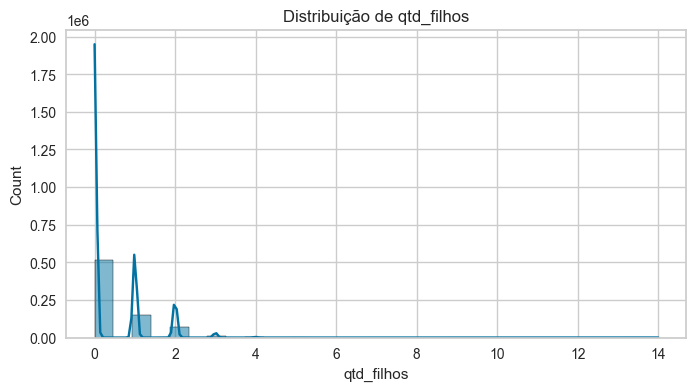

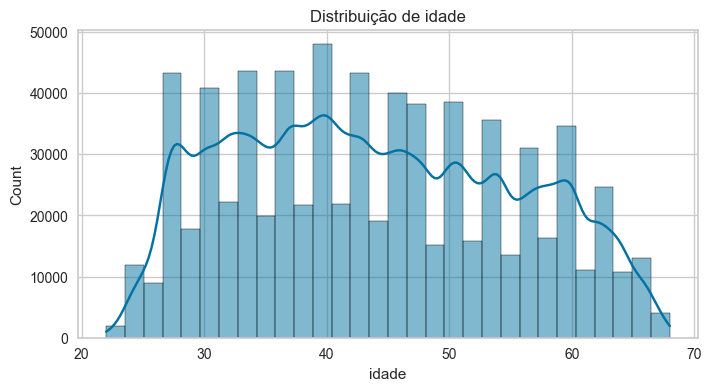

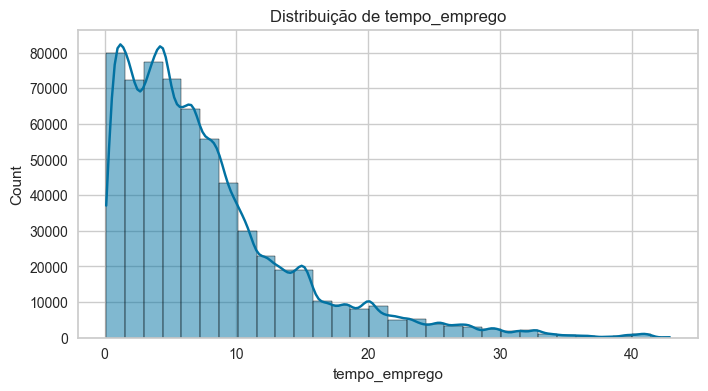

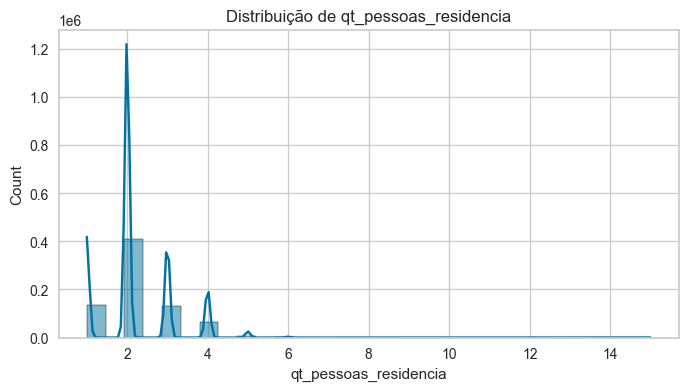

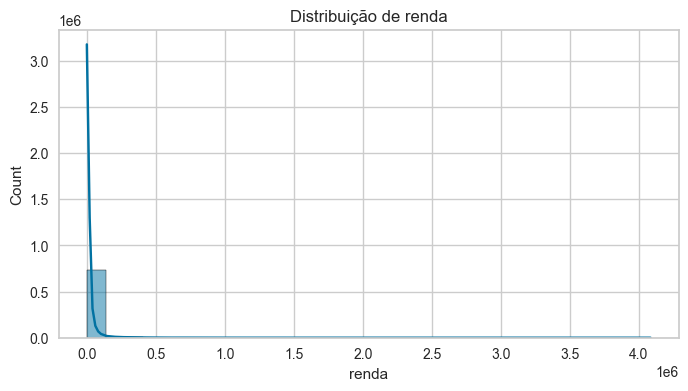

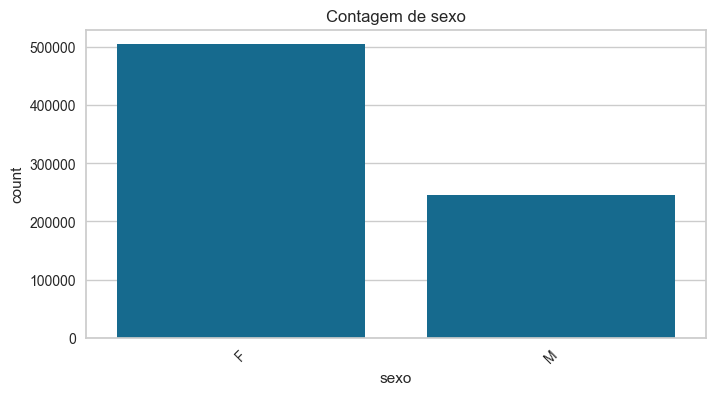

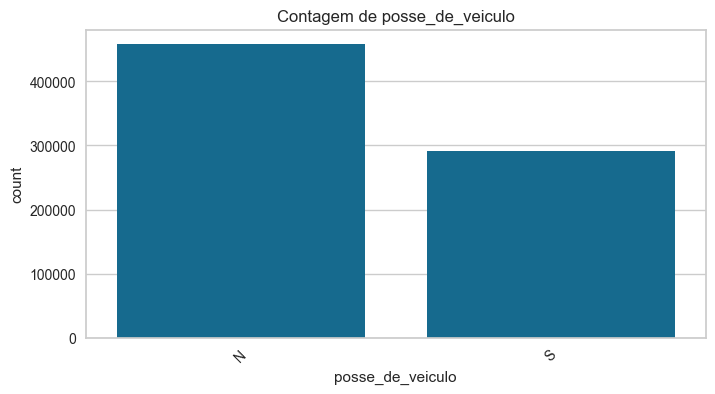

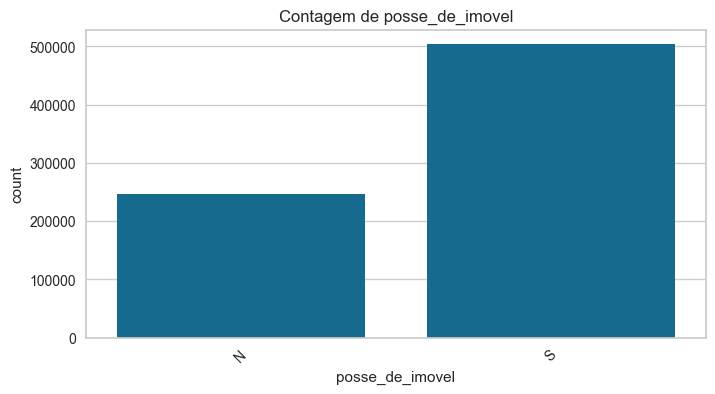

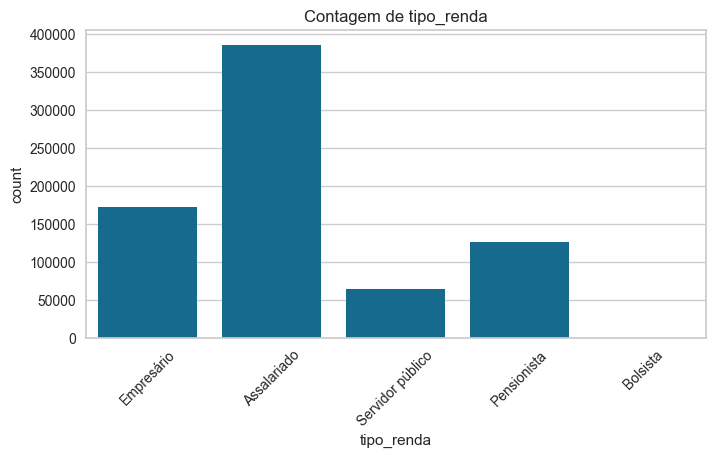

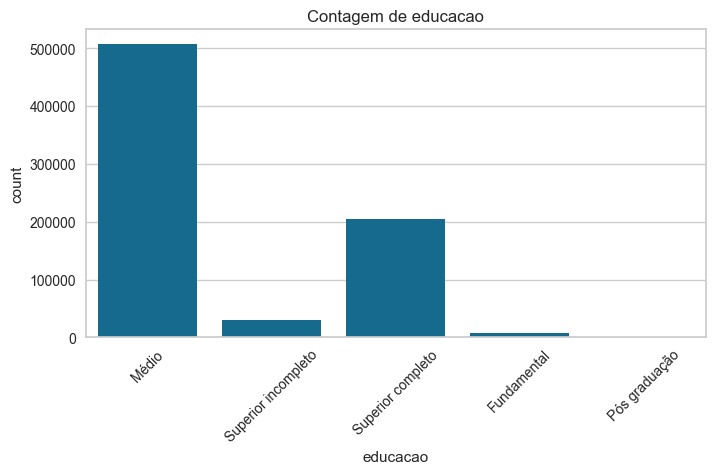

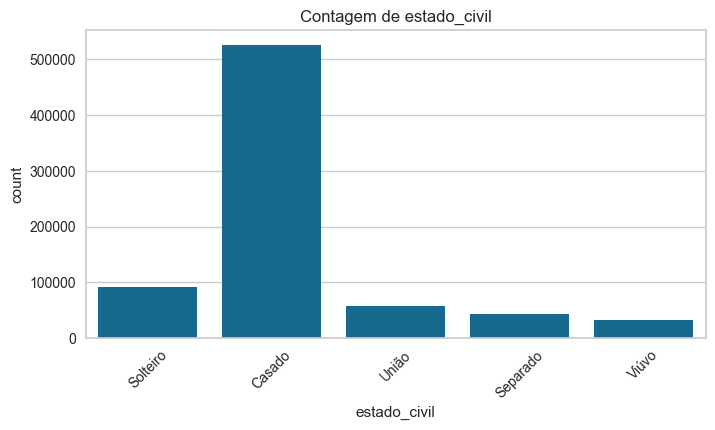

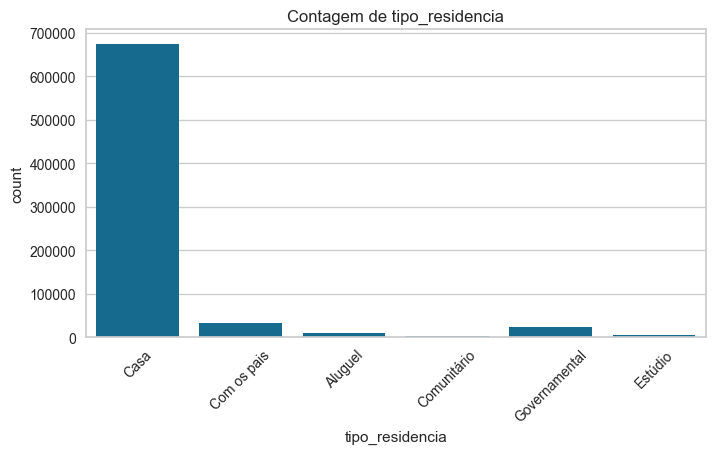

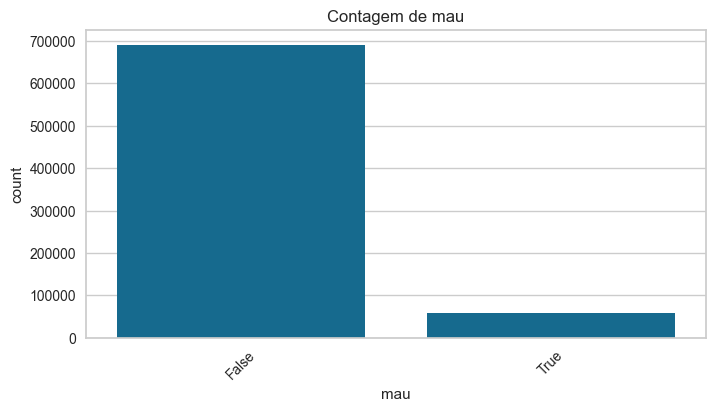

In [4]:
print("Linhas por mês:")
print(df['data_ref'].value_counts().sort_index())

num_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
for var in num_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[var], bins=30, kde=True)
    plt.title(f'Distribuição de {var}')
    plt.show()

cat_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']
for var in cat_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=var, data=df)
    plt.title(f'Contagem de {var}')
    plt.xticks(rotation=45)
    plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

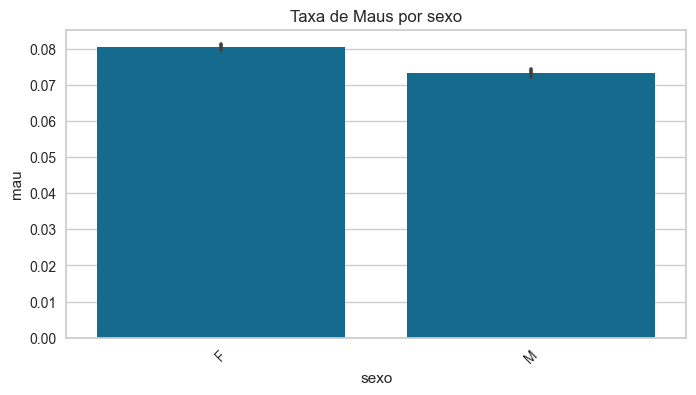

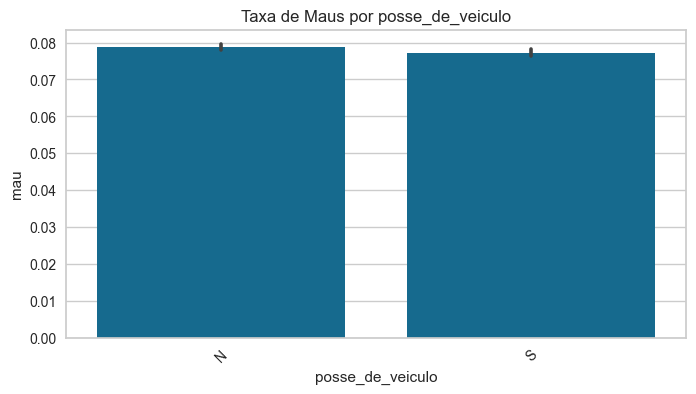

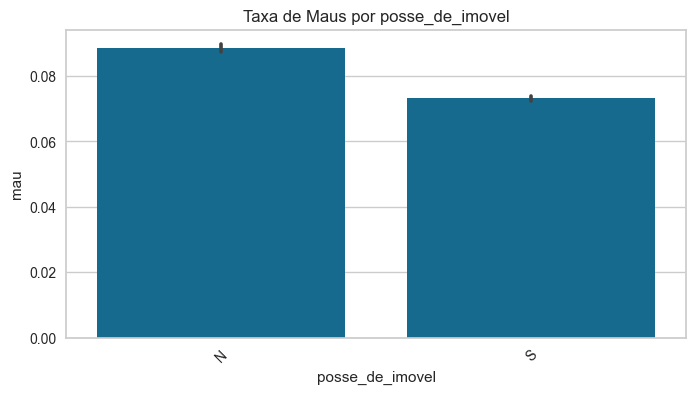

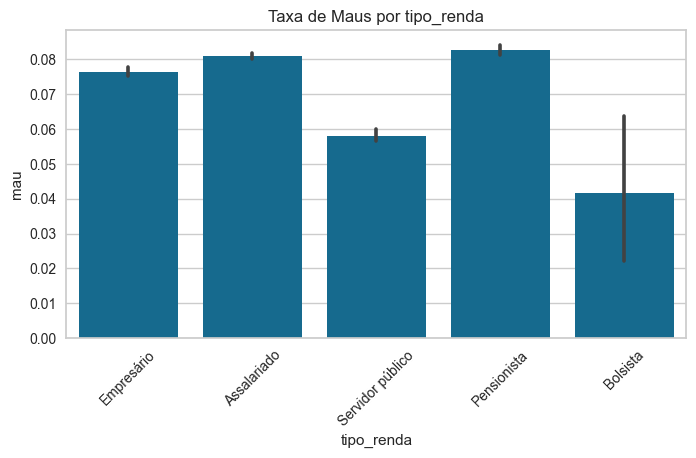

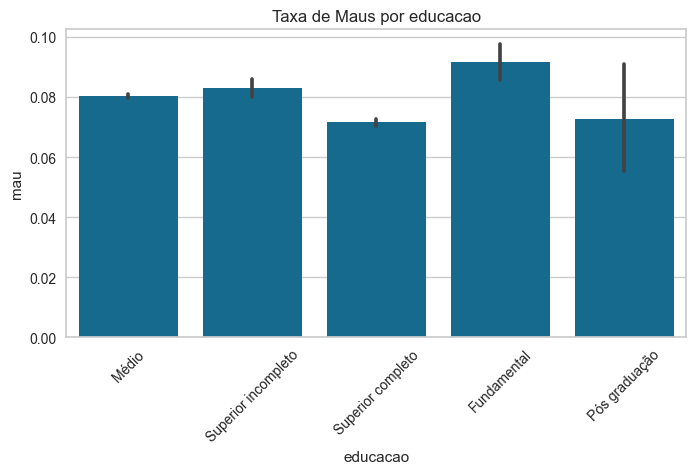

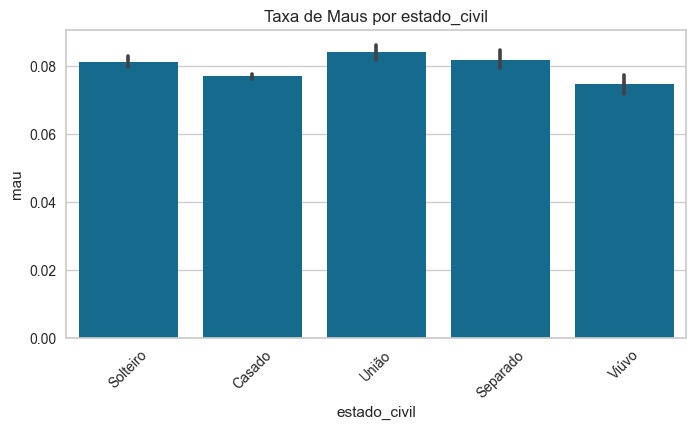

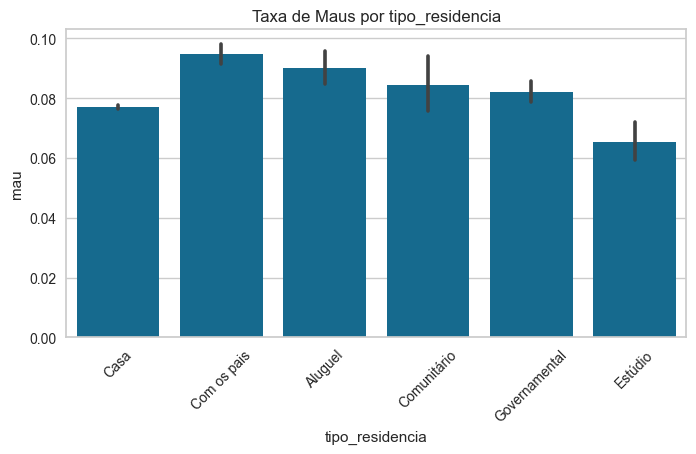

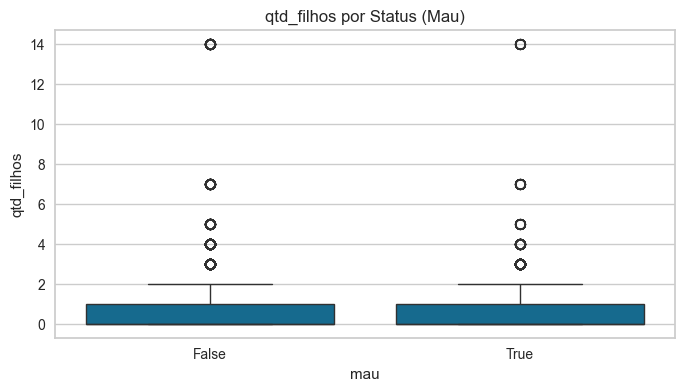

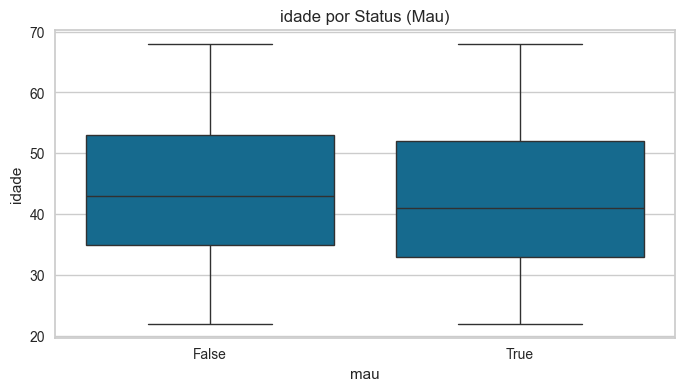

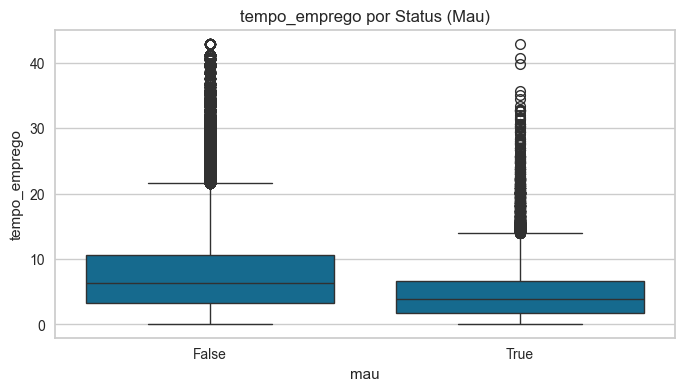

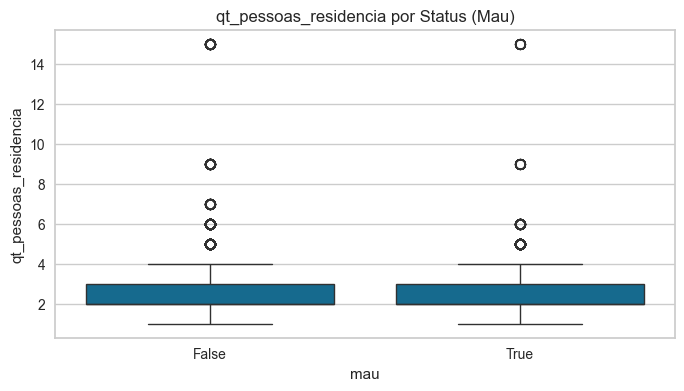

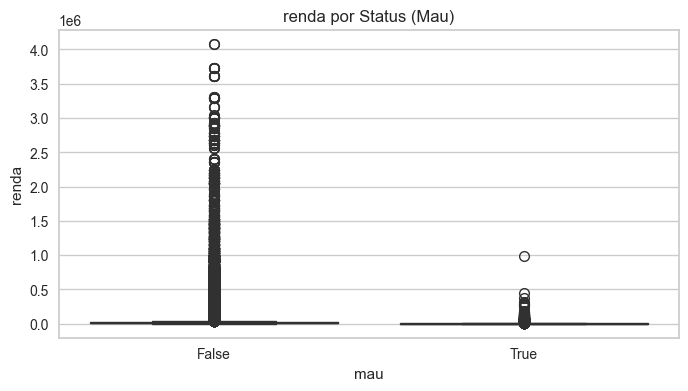

In [5]:
for var in cat_vars:
    if var != 'mau':
        plt.figure(figsize=(8, 4))
        sns.barplot(x=var, y='mau', data=df)
        plt.title(f'Taxa de Maus por {var}')
        plt.xticks(rotation=45)
        plt.show()

for var in num_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='mau', y=var, data=df)
    plt.title(f'{var} por Status (Mau)')
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [6]:
df_train['tempo_emprego'] = df_train['tempo_emprego'].fillna(0)
df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(0)

cap_renda = df_train['renda'].quantile(0.99)
df_train['renda'] = np.where(df_train['renda'] > cap_renda, cap_renda, df_train['renda'])
df_oot['renda'] = np.where(df_oot['renda'] > cap_renda, cap_renda, df_oot['renda'])

df_train['log_renda'] = np.log1p(df_train['renda'])
df_oot['log_renda'] = np.log1p(df_oot['renda'])

df_train['mau'] = df_train['mau'].astype(int)
df_oot['mau'] = df_oot['mau'].astype(int)

formula = '''mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + 
             tipo_renda + educacao + estado_civil + tipo_residencia + 
             idade + tempo_emprego + qt_pessoas_residencia + log_renda'''

model = smf.logit(formula, data=df_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.200442
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599974
Method:                           MLE   Df Model:                           25
Date:                Fri, 26 Dec 2025   Pseudo R-squ.:                  0.1282
Time:                        18:39:42   Log-Likelihood:            -1.2026e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            6.0785      0.197     30.77

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [7]:
taxa_mau = df.mau.value_counts().iloc[1] / df.shape[0]

df_train['pred'] = model.predict(df_train)
df_oot['pred'] = model.predict(df_oot)

def evaluate(y_true, y_pred, name="Dataset"):
    auc = roc_auc_score(y_true, y_pred)
    gini = 2 * auc - 1
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    ks = max(tpr - fpr)
    
    acc = accuracy_score(y_true, y_pred > taxa_mau)
    
    print(f"--- {name} ---")
    print(f"AUC: {auc:.4f}")
    print(f"Gini: {gini:.4f}")
    print(f"KS: {ks:.4f}")
    print(f"Acurácia: {acc:.4f}")

evaluate(df_train['mau'], df_train['pred'], "Treino")
evaluate(df_oot['mau'], df_oot['pred'], "OOT")

--- Treino ---
AUC: 0.7702
Gini: 0.5404
KS: 0.3985
Acurácia: 0.7584
--- OOT ---
AUC: 0.7390
Gini: 0.4780
KS: 0.3468
Acurácia: 0.4354


## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [8]:
num_imputer = SimpleImputer(strategy='mean')

cat_imputer = SimpleImputer(strategy='most_frequent')

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [9]:
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.caps = {}
        
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            for col in X.select_dtypes(include=[np.number]).columns:
                q1 = X[col].quantile(0.25)
                q3 = X[col].quantile(0.75)
                iqr = q3 - q1
                self.caps[col] = (q1 - self.factor * iqr, q3 + self.factor * iqr)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if isinstance(X_copy, pd.DataFrame):
            for col, (lower, upper) in self.caps.items():
                if col in X_copy.columns:
                    X_copy[col] = X_copy[col].clip(lower=lower, upper=upper)
        return X_copy

outlier_handler = OutlierCapper(factor=3.0)


df_train['log_renda'] = np.log(df_train['renda'])
df_oot['log_renda'] = np.log(df_oot['renda'])

print("Variável log_renda criada com sucesso.")
print(df_train[['renda', 'log_renda']].head())

Variável log_renda criada com sucesso.
      renda  log_renda
0   2515.39   7.830183
1   3180.19   8.064696
2   1582.29   7.366628
3  13721.17   9.526695
4   2891.08   7.969385


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [10]:
selector = SelectKBest(score_func=f_classif, k=10)

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [11]:
pca = PCA(n_components=5)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [12]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [13]:
numeric_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'log_renda']
categorical_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('outlier', OutlierCapper(factor=3.0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('pca', PCA(n_components=5)),
                      ('classifier', LogisticRegression())])

### Treinar um modelo de regressão logistica com o resultado

In [14]:
X_train_sk = df_train.drop(['mau', 'data_ref', 'index', 'pred'], axis=1, errors='ignore')
y_train_sk = df_train['mau']

X_oot_sk = df_oot.drop(['mau', 'data_ref', 'index', 'pred'], axis=1, errors='ignore')
y_oot_sk = df_oot['mau']

clf.fit(X_train_sk, y_train_sk)

y_pred_oot = clf.predict_proba(X_oot_sk)[:, 1]
evaluate(y_oot_sk, y_pred_oot, "Pipeline OOT")

--- Pipeline OOT ---
AUC: 0.7245
Gini: 0.4489
KS: 0.3243
Acurácia: 0.5032


### Salvar o pickle file do modelo treinado

In [15]:
nome_arquivo = 'regressao_logistica.pkl'
pickle.dump(clf, open(nome_arquivo, 'wb'))
print(f"Modelo salvo em {nome_arquivo}")

Modelo salvo em regressao_logistica.pkl


# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(50000, 16)"
4,Transformed data shape,"(76218, 30)"
5,Transformed train set shape,"(61218, 30)"
6,Transformed test set shape,"(15000, 30)"
7,Ignore features,3
8,Numeric features,5
9,Categorical features,7


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8617,0.7661,0.3477,0.2431,0.2861,0.2122,0.2164
1,0.8697,0.7884,0.3978,0.2782,0.3274,0.2578,0.2629
2,0.8680,0.7747,0.3513,0.2586,0.2979,0.2269,0.2301
3,0.8651,0.7453,0.3226,0.2413,0.2761,0.2034,0.2060
4,0.8666,0.7755,0.3584,0.2577,0.2999,0.2283,0.2321
5,0.8580,0.7396,0.2796,0.2086,0.2389,0.1624,0.1645
6,0.8654,0.7846,0.3429,0.2507,0.2896,0.2172,0.2205
7,0.8551,0.7362,0.2964,0.2112,0.2467,0.1690,0.1720
8,0.8626,0.7490,0.3071,0.2306,0.2634,0.1893,0.1917


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7746,0.7880,0.6487,0.2076,0.3145,0.2203,0.2719
1,0.7460,0.8076,0.7168,0.1980,0.3103,0.2119,0.2782
2,0.7334,0.7893,0.6559,0.1794,0.2818,0.1790,0.2361
3,0.7131,0.7678,0.6631,0.1689,0.2693,0.1629,0.2223
4,0.7497,0.7720,0.6487,0.1887,0.2924,0.1927,0.2473
5,0.7463,0.7550,0.6129,0.1798,0.2780,0.1765,0.2257
6,0.7611,0.7987,0.6679,0.2011,0.3091,0.2122,0.2685
7,0.7340,0.7607,0.6321,0.1761,0.2755,0.1719,0.2249
8,0.7166,0.7718,0.6714,0.1728,0.2749,0.1691,0.2297


Fitting 10 folds for each of 10 candidates, totalling 100 fits


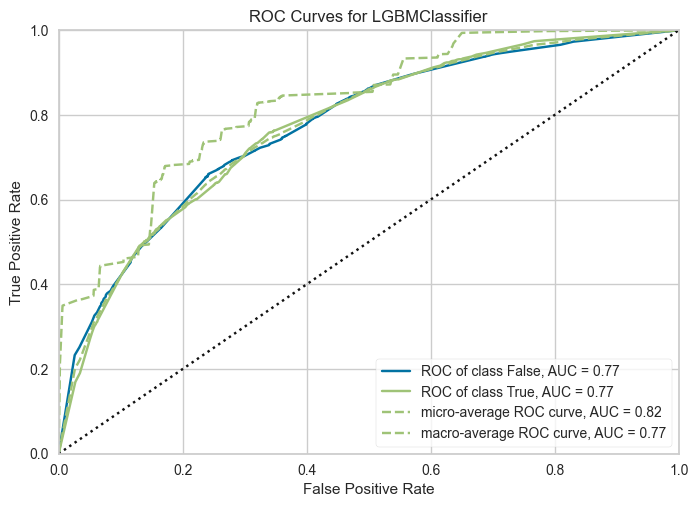

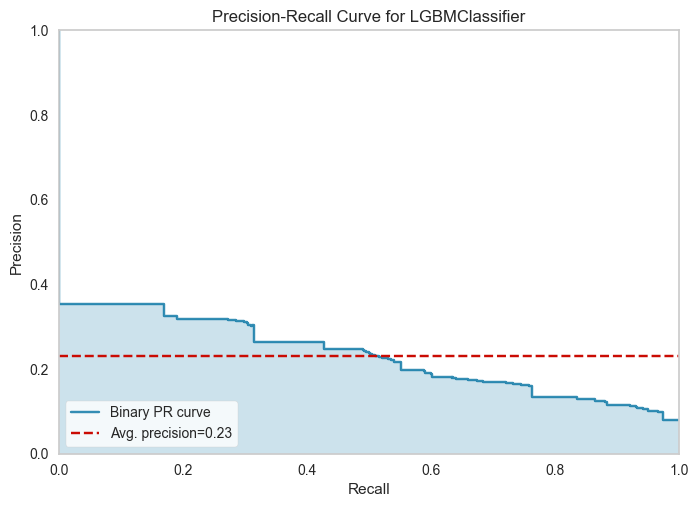

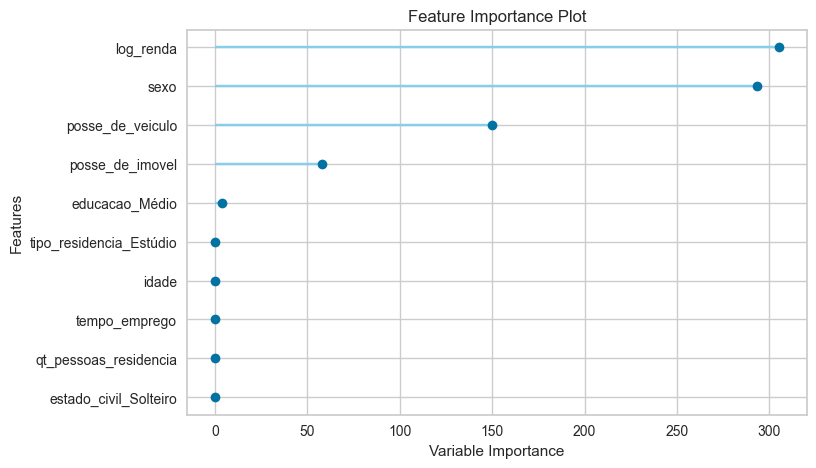

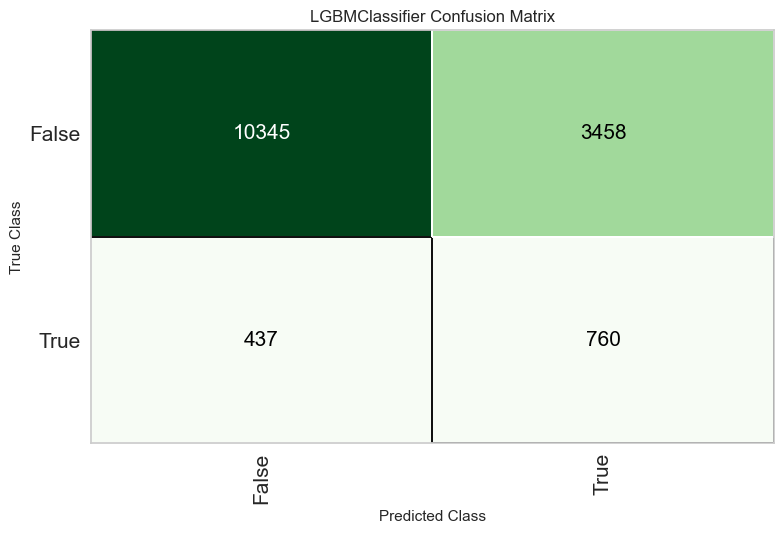

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['qtd_filhos', 'idade', 'tempo_emprego',
                             'qt_pessoas_residencia', 'log_renda'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='mean')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                             'tipo_renda', 'educacao', 'estado_civil',
                             'tipo_residencia'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
                                              keep_empty_features=Fal

In [16]:
data_pycaret = df.sample(50000, random_state=123)
data_pycaret['log_renda'] = np.log(data_pycaret['renda'])
exp_clf = setup(data=data_pycaret,
                target='mau', 
                ignore_features=['data_ref', 'index', 'renda'],
                remove_outliers=True,
                transformation=True,
                session_id=123,
                fix_imbalance=True,
                normalize=True)

lgbm = create_model('lightgbm')
tuned_lgbm = tune_model(lgbm, optimize='AUC')
final_lgbm = finalize_model(tuned_lgbm)

plot_model(tuned_lgbm, plot='auc')
plot_model(tuned_lgbm, plot='pr')
plot_model(tuned_lgbm, plot='feature')
plot_model(tuned_lgbm, plot='confusion_matrix')

final_lgbm = finalize_model(tuned_lgbm)

save_model(final_lgbm, 'modelo_final_lightgbm')

loaded_model_saved = load_model('modelo_final_lightgbm')

loaded_model_saved.named_steps

### Salvar o arquivo do modelo treinado

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.